<a href="https://colab.research.google.com/github/nireasir/auth-dws-ml2526/blob/main/MLex10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [33]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN

# Ερώτημα 1

In [4]:
df=pd.read_csv("dataset.csv")
cols_to_drop = ["Unnamed: 0", "track_id", "artists", "album_name", "track_name"]
cols_to_drop=[c for c in cols_to_drop if c in df.columns]
metadata_df = df[cols_to_drop + ["track_genre"]].copy()
df_clean=df.drop(columns=cols_to_drop)

df_ohe = pd.get_dummies(df_clean, columns=["track_genre"], prefix="genre", dtype=int)

# Ερώτημα 2

In [6]:
scaler=StandardScaler()
numeric_cols=df_ohe.select_dtypes(include=["int64", "float64"]).columns
df_scaled=df_ohe.copy()
df_scaled[numeric_cols]=scaler.fit_transform(df_ohe[numeric_cols])

# Ερώτημα 3

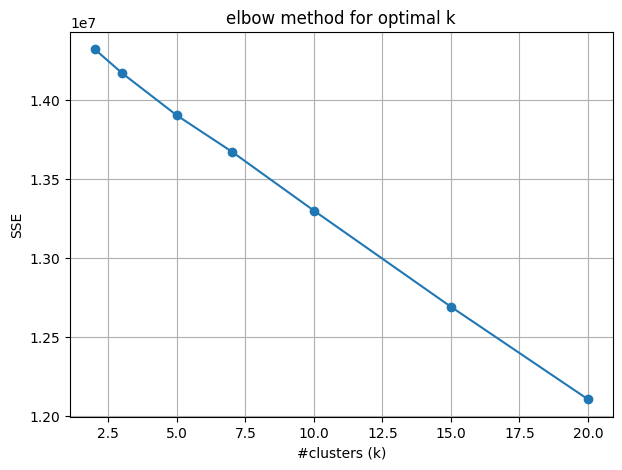

In [12]:
x = df_scaled.values
ks = [2, 3, 5, 7, 10, 15, 20]
sse=[]
for k in ks:
  kmeans=KMeans(n_clusters=k,init='k-means++',n_init=10,random_state=42)
  kmeans.fit(x)
  sse.append(kmeans.inertia_)
plt.figure(figsize=(7,5))
plt.plot(ks, sse, marker='o')
plt.xlabel("#clusters (k)")
plt.ylabel("SSE")
plt.title("elbow method for optimal k")
plt.grid(True)
plt.show()

# Ερώτημα 4

In [13]:
kmeans2=KMeans(n_clusters=7,init='k-means++',n_init=10,random_state=42)
kmeans2.fit(x)
labels=kmeans2.labels_
print(labels)

[5 5 5 ... 5 5 5]


# Ερώτημα 5

Cluster 0: dominant genre = death-metal, percentage = 6.09%
Cluster 1: dominant genre = deep-house, percentage = 4.60%
Cluster 2: dominant genre = sleep, percentage = 6.92%
Cluster 3: dominant genre = dance, percentage = 5.89%
Cluster 4: dominant genre = breakbeat, percentage = 9.28%
Cluster 5: dominant genre = brazil, percentage = 4.84%
Cluster 6: dominant genre = funk, percentage = 7.68%


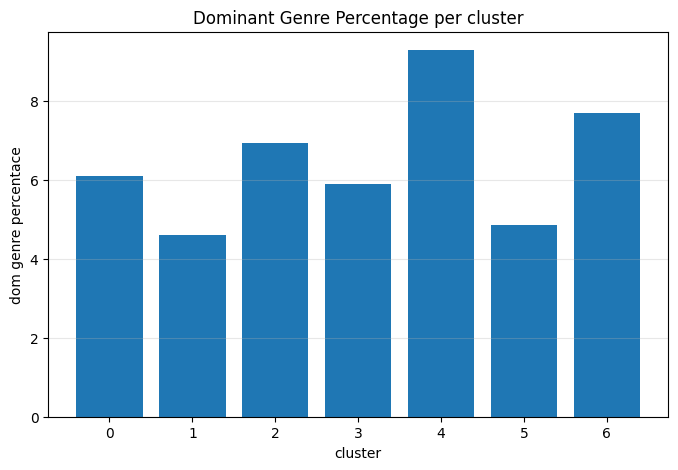

In [17]:
df_genre_cluster = pd.DataFrame({
    "cluster": labels,
    "track_genre": df["track_genre"].values
})
clusters = sorted(df_genre_cluster["cluster"].unique())
dominant_pct = []
dominant_genre = []
for c in clusters:
    sub = df_genre_cluster[df_genre_cluster["cluster"] == c]
    counts = sub["track_genre"].value_counts()
    dom_g = counts.idxmax()
    pct = (counts.max() / len(sub)) * 100
    dominant_genre.append(dom_g)
    dominant_pct.append(pct)
    print(f"Cluster {c}: dominant genre = {dom_g}, percentage = {pct:.2f}%")
plt.figure(figsize=(8, 5))
plt.bar(clusters, dominant_pct)
plt.xlabel("cluster")
plt.ylabel("dom genre percentace")
plt.title("Dominant Genre Percentage per cluster")
plt.xticks(clusters)
plt.grid(axis="y", alpha=0.3)
plt.show()

# Ερώτημα 6

In [29]:
song = "Paradise City"
meta = metadata_df.copy()
meta["cluster"] = labels
song_row = meta[meta["track_name"] == song]
if song_row.empty:
    raise ValueError("Not in dataset")
song_index = song_row.index[0]
song_cluster = int(song_row.loc[song_index, "cluster"])
print("Song:", meta.loc[song_index, "track_name"])
print("Artist:", meta.loc[song_index, "artists"])
print("Cluster:", song_cluster)
cluster_indices = meta[meta["cluster"] == song_cluster].index
X_cluster = df_scaled.loc[cluster_indices].astype(float).values
x_song = df_scaled.loc[song_index].astype(float).values
distances = np.linalg.norm(X_cluster-x_song, axis=1)
dist_df = pd.DataFrame({
    "index": cluster_indices,
    "distance": distances
})
dist_df = dist_df[dist_df["index"] != song_index]
top3 = dist_df.nsmallest(3, "distance")
print("\nTop-3 similar songs:")
for rank, (_, row) in enumerate(top3.iterrows(), start=1):
    idx = int(row["index"])
    print(f"{rank}. {meta.loc[idx, 'track_name']} — {meta.loc[idx, 'artists']} with distance={row['distance']:.4f}")

Song: Paradise City
Artist: Guns N' Roses
Cluster: 0

Top-3 similar songs:
1. Paradise City — Guns N' Roses with distance=0.7336
2. Fade To Black - Remastered — Metallica with distance=2.0071
3. Man in the Box — Alice In Chains with distance=2.0363


Θεωρώ ότι ταιριάζουν τα αποτελέσματα καθώς βλέπουμε στη πρώτη θέση το Paradise City που είναι διαφορετική εγγραφή του τραγουδιού (πιθανό remix ή με άλλα παρόμοια ηχητικά χαρακτηριστικά). Τα τραγούδια Fade in Black και Man in the box είναι επίσης ροκ με παρόμοιο ρυθμό και ένταση με το Paradise City

# Ερώτημα 7

In [32]:
song = "Paradise City"
meta = metadata_df.copy()
meta["cluster"] = labels
song_row = meta[meta["track_name"] == song]
if song_row.empty:
    raise ValueError("Το τραγούδι δεν βρέθηκε στο dataset.")
song_index = song_row.index[0]
song_cluster = int(meta.loc[song_index, "cluster"])
print("Song:", meta.loc[song_index, "track_name"])
print("Artist:", meta.loc[song_index, "artists"])
print("Cluster:", song_cluster)
cluster_indices = meta[meta["cluster"] == song_cluster].index
X_cluster = df_scaled.loc[cluster_indices].astype(float).values
x_song = df_scaled.loc[song_index].astype(float).values.reshape(1, -1)
sims = cosine_similarity(x_song, X_cluster)[0]
cos_dist = 1 - sims
dist_df = pd.DataFrame({
    "index": cluster_indices,
    "cosine_distance": cos_dist,
    "cosine_similarity": sims
})
dist_df = dist_df[dist_df["index"] != song_index]
top3 = dist_df.nsmallest(3, "cosine_distance")
print("\n Top-3 similar songs:")
for rank, (_, row) in enumerate(top3.iterrows(), start=1):
    idx = int(row["index"])
    print(f"{rank}. {meta.loc[idx, 'track_name']} — {meta.loc[idx, 'artists']} with "
          f"cos_dist={row['cosine_distance']:.4f}")

Song: Paradise City
Artist: Guns N' Roses
Cluster: 0

 Top-3 similar songs:
1. Paradise City — Guns N' Roses with cos_dist=0.0021
2. Fade To Black - Remastered — Metallica with cos_dist=0.0155
3. Rocket Queen — Guns N' Roses with cos_dist=0.0159


Βλέπουμε ότι οι συστάσεις είναι σχετικά καλύτερες, καθώς στις top3 θέσεις έχουμε και δεύτερο τραγούδι του ίδιου συγκροτήματος

# Ερώτημα 8

# Ερώτημα 9

In [34]:
x = df_scaled.astype(float).values
dbscan=DBSCAN(eps=2.5,min_samples=10)
db_labels = dbscan.fit_predict(x)
unique_labels = set(db_labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(db_labels).count(-1)
print("#clusters found:", n_clusters)
print("noise points:", n_noise)

#clusters found: 172
noise points: 9976


O DBSCAN δημιούργησε πολλά περισσότερα clusters (172) σε σχέση με τον KMeans(7). Η σημαντική διαφορά στον αριθμό των clusters οφείλεται στο ότι ο KMeans βασίζεται σε κεντροειδή και ελαχιστοποίηση αποστάσεων, ενώ ο DBSCAN εντοπίζει συστάδες με βάση την τοπική πυκνότητα των δεδομένων.